In [2]:
import wandb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
wandb.login()

wandb: Currently logged in as: emiel-witting (fsoconut) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
api = wandb.Api()
runs = api.runs("fsoconut/generative-modelling", {"group": "MNIST-base"})

# Get summary metrics for each run
summaries = []
for run in runs:
    summaries.append(run.summary._json_dict)

print(f"Found {len(summaries)} runs")
print("\nSummary metrics:")
if len(summaries) > 0:
    for key in summaries[0].keys():
        print(f"- {key}")

Found 50 runs

Summary metrics:
- Training/acc
- Training/energy_fake
- Training/energy_real
- Training/l1
- Training/loss
- Training/loss_clf
- Training/loss_gen
- _runtime
- _step
- _timestamp
- _wandb
- batch
- epoch


In [5]:
# Convert list of summary dicts to dataframe
df = pd.DataFrame(summaries)
df.head()

,Training/acc,Training/energy_fake,Training/energy_real,Training/l1,Training/loss,Training/loss_clf,Training/loss_gen,_runtime,_step,_timestamp,_wandb,batch,epoch,Testing/acc
0,0.656250,129.795609,45.244324,1.070363,-83.436958,1.114325,-84.551285,153.371846,616,1.749116e+09,{'runtime': 154},616,1,NaN
1,0.578125,135.906082,38.095322,1.145959,-96.223640,1.587114,-97.810753,116.643087,454,1.749116e+09,{'runtime': 116},454,1,NaN
2,0.609375,141.951385,48.276695,1.282979,-92.368660,1.306033,-93.674690,101.452531,412,1.749117e+09,{'runtime': 101},412,1,NaN
3,0.421875,149.537659,48.674416,1.147568,-96.517769,4.345469,-100.863235,153.695486,609,1.749117e+09,{'runtime': 154},609,1,NaN
4,0.390625,160.652679,79.543037,0.938155,-78.788467,2.321184,-81.109650,296.199832,1223,1.749117e+09,{'runtime': 297},1222,2,0.86112


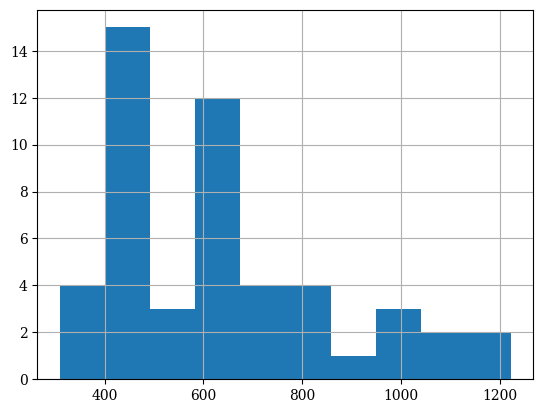

Shapiro-Wilk test - statistic: 0.9066, p-value: 7.9981e-04


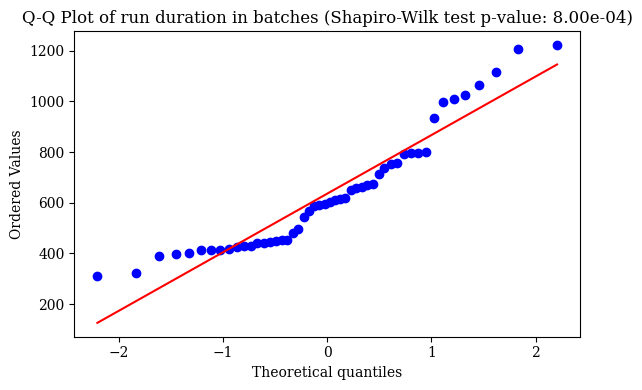

In [20]:
df['batch'].hist()
plt.show()
# Create Q-Q plot to test for normality of batch distribution
from scipy import stats

# Get batch data
batch_data = df['batch'].values

# Create Q-Q plot
fig = plt.figure(figsize=(6,4))
stats.probplot(batch_data, dist="norm", plot=plt)

# Set font to serif to match other plots
plt.rcParams['font.family'] = 'serif'


# Perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(batch_data)
print(f'Shapiro-Wilk test - statistic: {stat:.4f}, p-value: {p:.4e}')

# Add title and adjust layout
plt.title(f'Q-Q Plot of run duration in batches (Shapiro-Wilk test p-value: {p:.2e})')
plt.tight_layout()


plt.show()


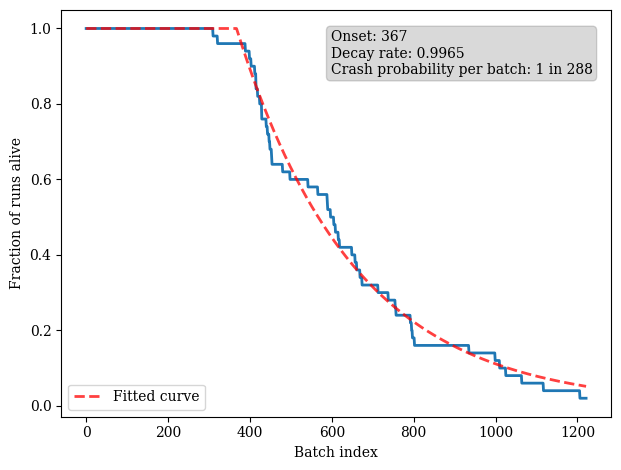

Onset: 367
Decay rate: 0.9965
Crash probability 1 in 288 batches


In [15]:
alive = np.zeros(df['batch'].max())
for i, row in df.iterrows():
    alive[0:row['batch']] += 1
alive /= len(runs)
ax = plt.gca()

# Set font to serif globally for this plot
plt.rcParams['font.family'] = 'serif'

plt.plot(alive, linewidth=2, alpha=1.0)
plt.xlabel('Batch index')
plt.ylabel('Fraction of runs alive')

# Fit exponential decay
from scipy.optimize import curve_fit
def exp_decay(x, rate, onset):
    return np.where(x < onset, 1, rate ** (x - onset))

xs = np.arange(len(alive))
popt, _ = curve_fit(exp_decay, xs, alive)
plt.plot(xs, exp_decay(xs, *popt), label='Fitted curve', linestyle='--', color='red', linewidth=2, alpha=0.75)

# Add parameter information as text on the plot
info_text = f'Onset: {round(popt[1])}\nDecay rate: {popt[0]:.4f}\nCrash probability per batch: 1 in {round(1 / (1-popt[0]))}'
plt.text(0.49, 0.95, info_text, transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='black', alpha=0.15))

plt.legend()
plt.tight_layout()
plt.savefig('crash_distr.png', dpi=300)
plt.show()

print(f'Onset: {round(popt[1])}')
print(f'Decay rate: {popt[0]:.4f}')
print(f'Crash probability 1 in {round(1 / (1-popt[0]))} batches')


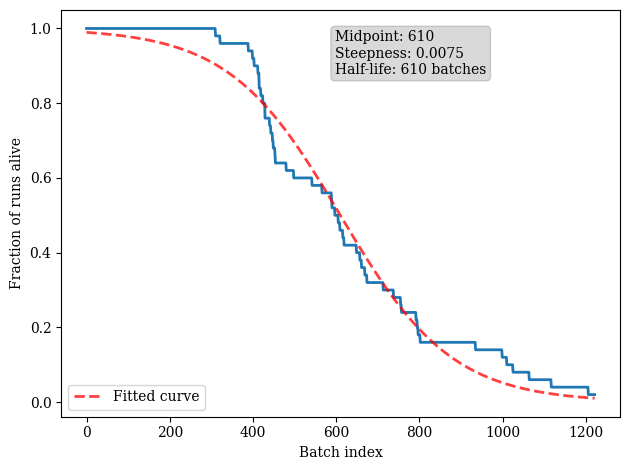

Midpoint: 610
Steepness: 0.0075
Half-life: 610 batches


In [8]:
alive = np.zeros(df['batch'].max())
for i, row in df.iterrows():
    alive[0:row['batch']] += 1
alive /= len(runs)
ax = plt.gca()

# Set font to serif globally for this plot
plt.rcParams['font.family'] = 'serif'

plt.plot(alive, linewidth=2, alpha=1.0)
plt.xlabel('Batch index')
plt.ylabel('Fraction of runs alive')

# Fit sigmoid
def sigmoid(x, x0, k):
    return 1 / (1 + np.exp(k * (x - x0)))

xs = np.arange(len(alive))
popt, _ = curve_fit(sigmoid, xs, alive, p0=[len(alive)/2, 0.01])
plt.plot(xs, sigmoid(xs, *popt), label='Fitted curve', linestyle='--', color='red', linewidth=2, alpha=0.75)

# Add parameter information as text on the plot
info_text = f'Midpoint: {round(popt[0])}\nSteepness: {popt[1]:.4f}\nHalf-life: {round(popt[0])} batches'
plt.text(0.49, 0.95, info_text, transform=ax.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='black', alpha=0.15))

plt.legend()
plt.tight_layout()
plt.savefig('crash_distr_sigmoid.png', dpi=300)
plt.show()

print(f'Midpoint: {round(popt[0])}')
print(f'Steepness: {popt[1]:.4f}')
print(f'Half-life: {round(popt[0])} batches')
